In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random Phase/Amplitude Model

## Simulating Ocean Surface Segments

Simulate 5 simple wave surface segments of 15 minutes each

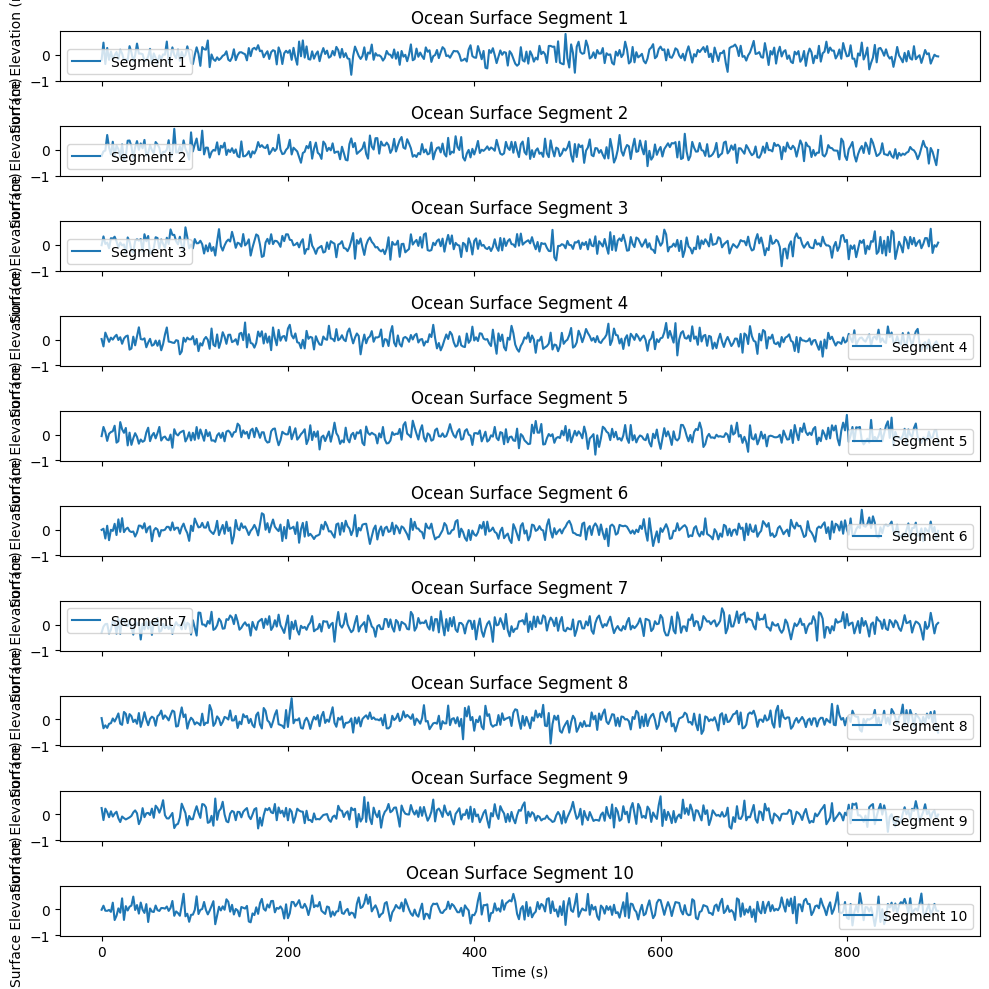

In [261]:

# Parameters
fs = 0.5  # Sampling frequency (1 Hz)
duration = 15 * 60  # 15 minutes = 900 seconds
n_samples = int(fs * duration)

# Number of segments
n_segments = 10

# Frequencies corresponding to FFT bins
freqs = np.fft.fftfreq(n_samples, d=1/fs)

# Generate 5 ocean surface segments
segments = []

for _ in range(n_segments):
    # Generate Rayleigh-distributed amplitudes
    sigma = 1.0  # Scale parameter for Rayleigh distribution
    scaling_factor = 5.0  # This could be adjusted based on desired wave height (meters)
    amplitudes = np.random.rayleigh(sigma, size=n_samples) * scaling_factor


    # Generate random phases (uniform distribution)
    random_phases = np.random.uniform(0, 2 * np.pi, size=n_samples)

    # Combine amplitude and phase into complex Fourier coefficients
    fft_signal = amplitudes * np.exp(1j * random_phases)

    # Inverse Fourier transform to get the reconstructed time-domain signal
    segment = np.fft.ifft(fft_signal).real  # Ensure real values
    segments.append(segment)

# Create subplots
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 10), sharex=True, sharey=True)

# Plot each segment in a separate subplot
time = np.linspace(0, duration, n_samples, endpoint=False)
for i in range(n_segments):
    axes[i].plot(time, segments[i], label=f"Segment {i+1}")
    axes[i].set_ylabel("Surface Elevation (m)")
    axes[i].set_title(f"Ocean Surface Segment {i+1}")
    axes[i].legend()

# Common labels
plt.xlabel("Time (s)")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## Extract Amplitude and Phase for each Segment

For each segment, as they are the same time period: $\Delta f = \frac{1}{D}$

In [236]:
segment_complex_values = []
segment_amplitudes = []

for i in range(n_segments):
    complex_values = np.fft.fft(segments[i])  # Calculate complex values for each segment
    segment_complex_values.append(complex_values)  # Append to segment complex store

    a = np.real(complex_values)
    b = np.imag(complex_values)
    segent_amplitude = np.sqrt(a**2 + b**2)
    segment_amplitudes.append(segent_amplitude)


Showcase the amplitude and phase spectrum from a single segment. 
Segment 1 is selected to serve as an example, showcasing the amplitude and phase spectrum. 

In [237]:
example_index = 1
amplitudes = []
phases = []

for i in range(len(segment_complex_values[example_index])):
    a = np.real(segment_complex_values[example_index][i])
    b = np.imag(segment_complex_values[example_index][i])
    amplitude = np.sqrt(a**2 + b**2)
    phase = np.angle(segment_complex_values[example_index][i])

    amplitudes.append(amplitude)
    phases.append(phase)

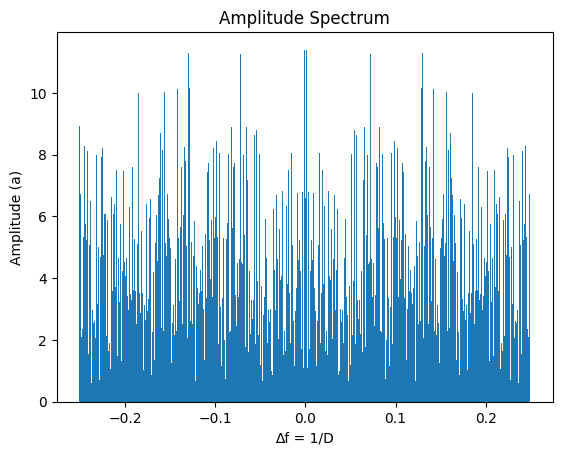

In [238]:
plt.bar(x=freqs, height=amplitudes, width=1/duration)
plt.title('Amplitude Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Amplitude (a)')
plt.show()

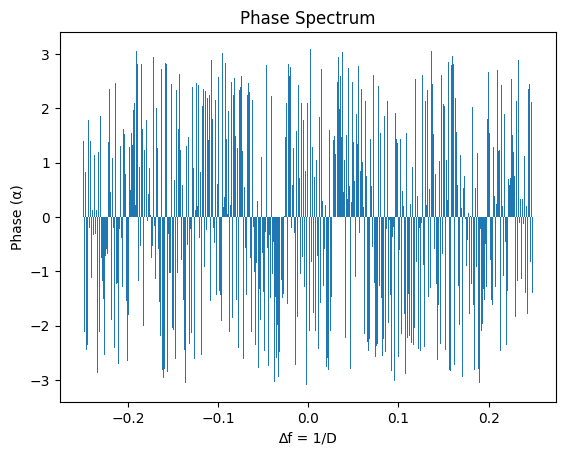

In [239]:
plt.bar(x=freqs, height=phases, width=1/duration)
plt.title('Phase Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Phase (α)')
plt.show()

For each segment we have identified amplitude values for each frequency. 
For each frequency, we can construct a Rayleigh and Uniform distribution for amplitude and spectrum respectively. 
In practice, to produce a deterministic spectrum, calculate the expected amplitude at each frequency (this value is used in amplitude spectrum).

In [240]:
f_example_indexes = [0, 2, 10, 50, 100, 150, 250, 300, 350, 400, 449]

example_expected_amplitudes = []

for i in f_example_indexes:
    N = n_segments  # Number of samples/ segments
    sigma_x_bar = np.sum([a[i] for a in segment_amplitudes])  # Sum of amplitudes at frequency i
    expected_x = (1/N) * sigma_x_bar  # Calculate expected value from random variable realizations
    example_expected_amplitudes.append(expected_x)

print(f'Expected Amplitudes/ mu {example_expected_amplitudes}')

Expected Amplitudes/ mu [np.float64(3.335594496285575), np.float64(3.561921772822355), np.float64(3.9196438091119683), np.float64(3.4389934342956283), np.float64(3.8310309114563452), np.float64(5.178989302983186), np.float64(5.025186221170756), np.float64(5.178989302983187), np.float64(3.831030911456345), np.float64(3.4389934342956274), np.float64(5.308408081463863)]


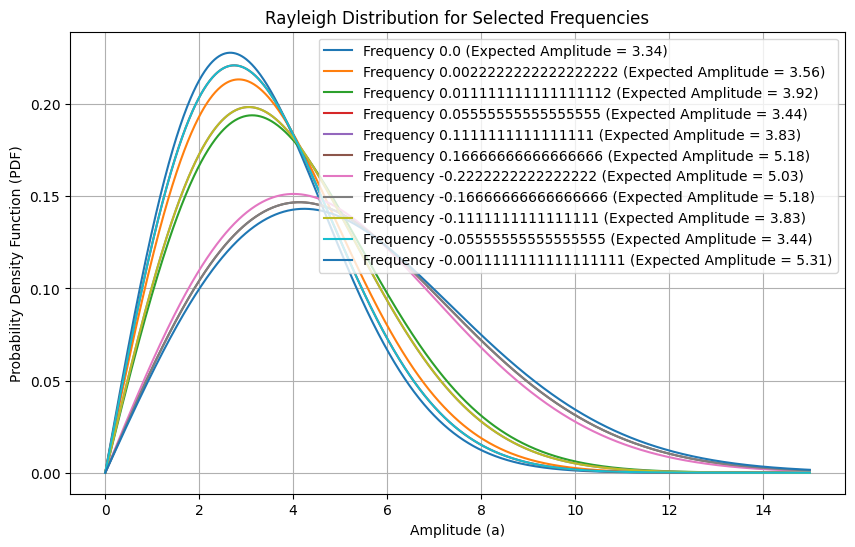

In [241]:
# Range of amplitudes for plotting the Rayleigh distribution
x = np.linspace(0, 15, 1000)

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Loop through the expected amplitudes and plot the corresponding Rayleigh distribution
for i, mu in enumerate(example_expected_amplitudes):
    sigma = mu * np.sqrt(2 / np.pi)  # Calculate scale parameter based on mu
    
    # Rayleigh distribution PDF formula
    rayleigh_pdf = (np.pi / 2) * (x / mu**2) * np.exp(-np.pi * x**2 / (4 * mu**2))
    
    # Plot the distribution
    plt.plot(x, rayleigh_pdf, label=f'Frequency {freqs[f_example_indexes[i]]} (Expected Amplitude = {mu:.2f})')

# Add labels, title, and legend
plt.title('Rayleigh Distribution for Selected Frequencies')
plt.xlabel('Amplitude (a)')
plt.ylabel('Probability Density Function (PDF)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Observed that negative frequencies are still in use currently.

In [242]:
expected_amplitudes = []

for i in range(len(freqs)):
    N = n_segments  # Number of samples/ segments
    sigma_x_bar = np.sum([a[i] for a in segment_amplitudes])  # Sum of amplitudes at frequency i
    expected_x = (1/N) * sigma_x_bar  # Calculate expected value from random variable realizations (mu)
    expected_amplitudes.append(expected_x)

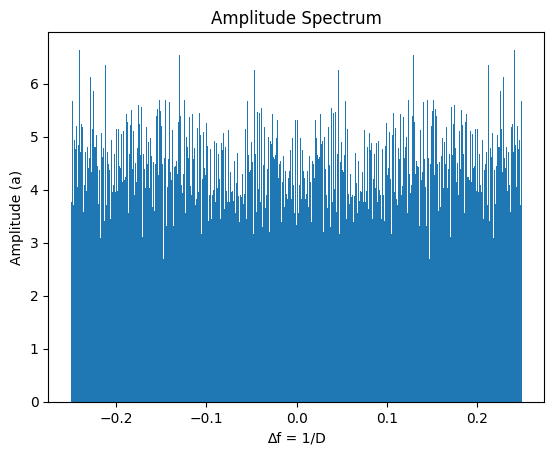

In [243]:
plt.bar(x=freqs, height=expected_amplitudes, width=1/duration)
plt.title('Amplitude Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Amplitude (a)')
plt.show()

Note that the above is a deterministic way to generate a deterministic amplitude spectrum as it, utilizes the expected values from each distribution. 
Below, we will generate simulations/ realizations of the ocean surface state, by sampling from each of the distributions to create a stochastic wave surface simulation. 

## Wave Simulation Realizations

Below we will draw from the distributions, to create realized sea surface state simulations. 
Each simulation will provide unique insights into the sea surface state. 

Additionally, to draw from a distribution this requires knowledge of inverse transform sampling of distributions. 

In [244]:
def rayleigh_cdf_inverse(mus, n_samples):
    U = np.random.uniform(0, 1, n_samples)
    sigmas = mus / np.sqrt(np.pi / 2)
    inverse_cdf = sigmas * np.sqrt(-2 * np.log(U))
    return inverse_cdf

Sample an amplitude from each frequency Rayleigh distribution, to create the below amplitude spectrum for this simulated wave.

In [245]:
sampled_amplitudes = rayleigh_cdf_inverse(expected_amplitudes,
                                          len(freqs)) 

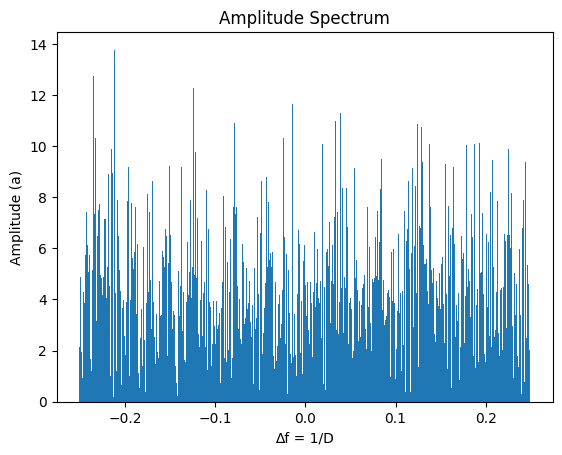

In [246]:
plt.bar(x=freqs, height=sampled_amplitudes, width=1/duration)
plt.title('Amplitude Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Amplitude (a)')
plt.show()

Sample phases from the uniform distribution.
Note for visualization continuity, I've allowed sampling between $-2 \pi$ and $2 \pi$.
This hould be betwee $[0, 2 \pi]$

In [247]:
# Generate random phases (uniform distribution)
sampled_phases = np.random.uniform(-2 * np.pi, 2 * np.pi, size=n_samples)

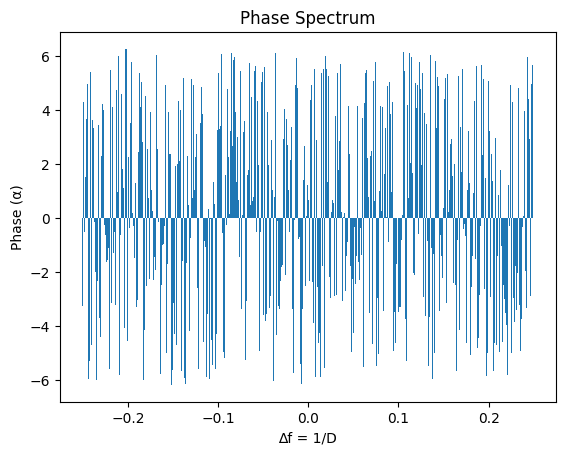

In [248]:
plt.bar(x=freqs, height=sampled_phases, width=1/duration)
plt.title('Phase Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Phase (α)')
plt.show()

In [249]:
fft_signal = sampled_amplitudes * np.exp(1j * sampled_phases)
sumulated_wave_surface = np.fft.ifft(fft_signal).real  # Ensure real values

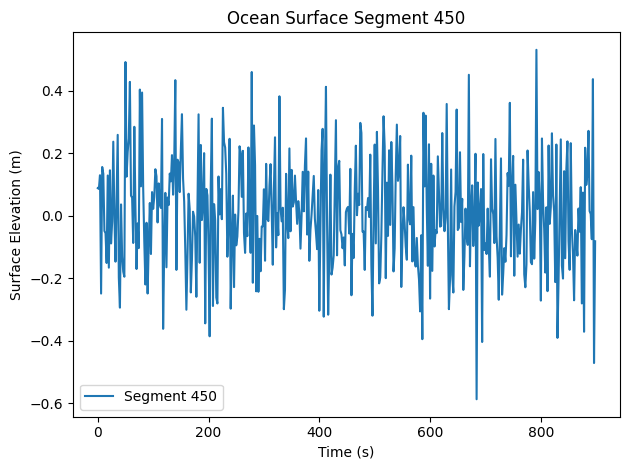

In [250]:
# Plot each segment in a separate subplot
time = np.linspace(0, duration, n_samples, endpoint=False)
plt.plot(time, sumulated_wave_surface, label=f"Segment {i+1}")
plt.ylabel("Surface Elevation (m)")
plt.title(f"Ocean Surface Segment {i+1}")
plt.legend()

# Common labels
plt.xlabel("Time (s)")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

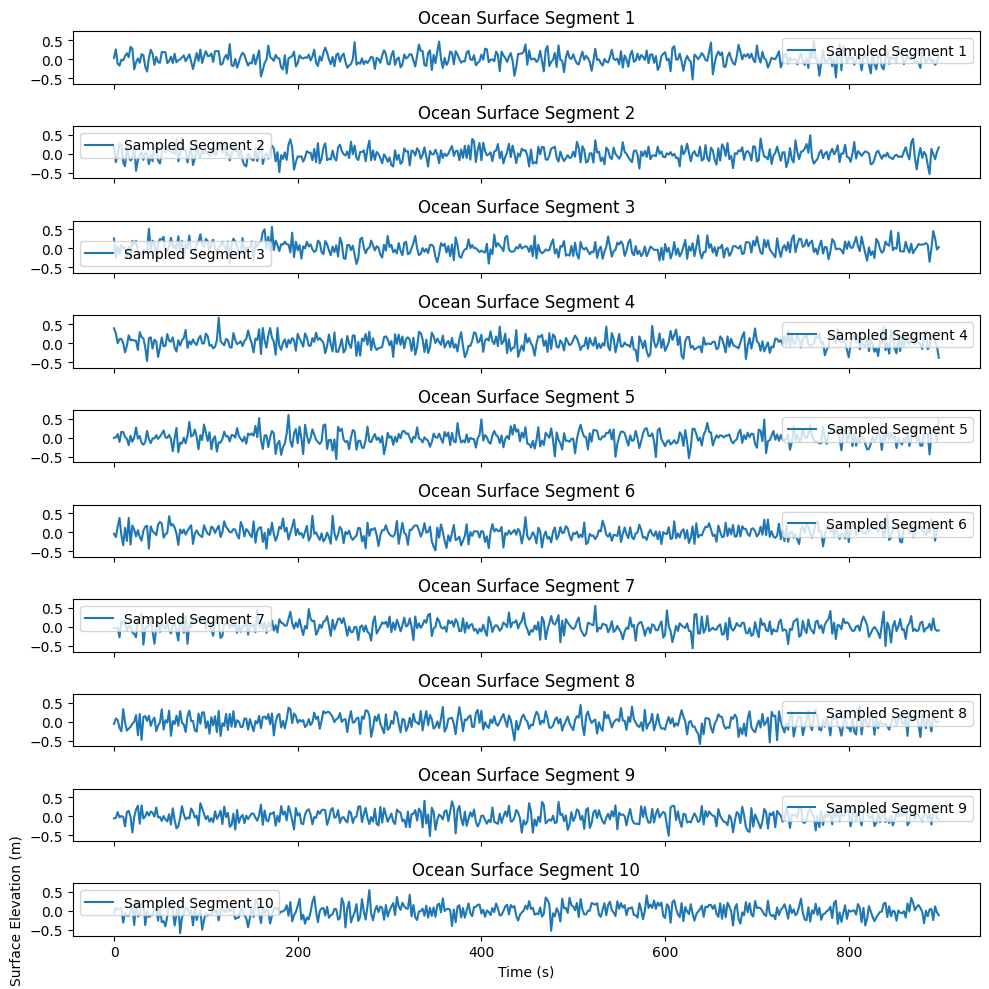

In [251]:
sampled_segments = []

for _ in range(n_segments):
    sampled_amplitudes = rayleigh_cdf_inverse(expected_amplitudes, len(freqs)) # Generate sampled amplitudes for a segment

    # Generate random phases (uniform distribution)
    random_phases = np.random.uniform(0, 2 * np.pi, size=n_samples)  # Uniform distribution to sample phases

    # Combine amplitude and phase into complex Fourier coefficients
    fft_signal = amplitudes * np.exp(1j * random_phases)

    # Inverse Fourier transform to get the reconstructed time-domain signal
    segment = np.fft.ifft(fft_signal).real  # Ensure real values
    sampled_segments.append(segment)

# Create subplots
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 10), sharex=True, sharey=True)

# Plot each segment in a separate subplot
time = np.linspace(0, duration, n_samples, endpoint=False)
for i in range(n_segments):
    axes[i].plot(time, sampled_segments[i], label=f"Sampled Segment {i+1}")
    axes[i].set_title(f"Ocean Surface Segment {i+1}")
    axes[i].legend()

# Common labels
plt.xlabel("Time (s)")
plt.ylabel("Surface Elevation (m)")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Variance Density Spectrum

Moving to the variance density spectrum.
We will use the `expected_amplitudes` variable as $E\{\underline{a}_i\}$ (only displaying positive frequencies).
This is deterministic

In [252]:
pos_freqs = freqs[: len(freqs)//2]
pos_sampled_amplitudes = expected_amplitudes[: len(freqs)//2]

$E\{\underline{a}_i\}$

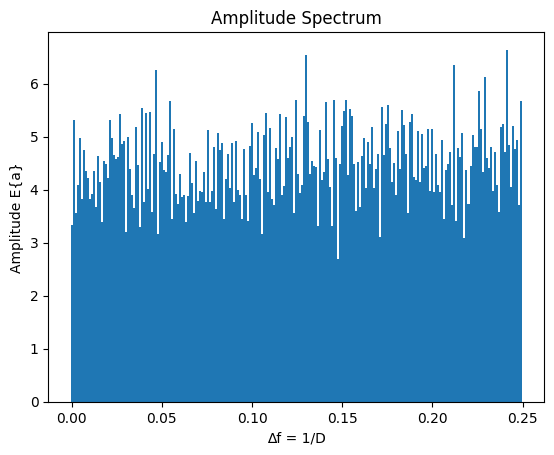

In [253]:
plt.bar(x=pos_freqs, height=pos_sampled_amplitudes, width=1/duration)
plt.title('Amplitude Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Amplitude E{a}')
plt.show()

Variance Spectrum = $E\{\frac{1}{2} \underline{a}_i^2\}$
To create a deterministic spectrum based on the Rayleigh distributions for each Frequency, we can use the following equation

$$\text{Variance} = \frac{(4 - \pi) * \mu^2}{\pi}$$

The above is derived from the known variance equation of the Rayleigh distribution

$$\text{Variance} = \sigma^2 * \frac{4 - \pi}{2}$$

Where $\sigma^2$ is the Rayleigh distribution scale paramater


In [254]:
variance_spectrum_theoretical = ((np.square(pos_sampled_amplitudes)) * (4 - np.pi)) / np.pi

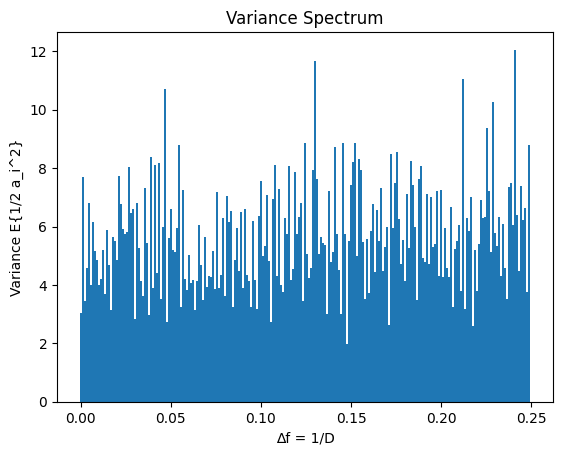

In [255]:
plt.bar(x=pos_freqs, height=variance_spectrum_theoretical, width=1/duration)
plt.title('Variance Spectrum')
plt.xlabel('∆f = 1/D')
plt.ylabel('Variance E{1/2 a_i^2}')
plt.show()

Create the discontinuous variance density spectrum

$$\frac{1}{\Delta f_i} E\{\frac{1}{2} \underline{a_i}^2\}$$

In [256]:
delta_f = 1 / duration
disc_variance_density = variance_spectrum_theoretical * delta_f


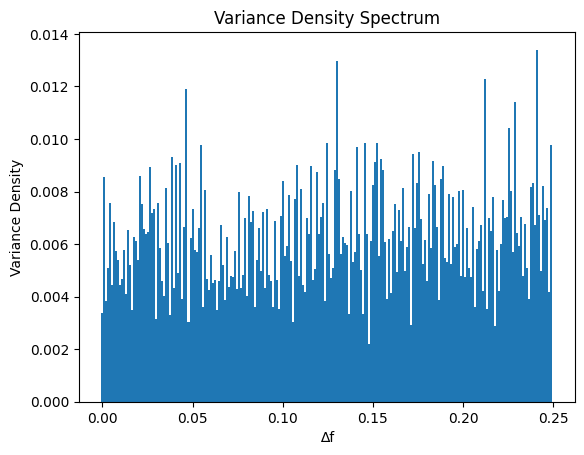

In [257]:
plt.bar(x=pos_freqs, height=disc_variance_density, width=1/duration)
plt.title('Variance Density Spectrum')
plt.xlabel('∆f')
plt.ylabel('Variance Density')
plt.show()

Continuous variance density spectrum is 

$$E(f) = \lim_{\Delta f \to\infty} \frac{1}{\Delta f} E\{\frac{1}{2} \underline{a_i}^2\}$$ 

In this case, shrinking $\Delta f$ will cause a higher resolution instead of approaching limit

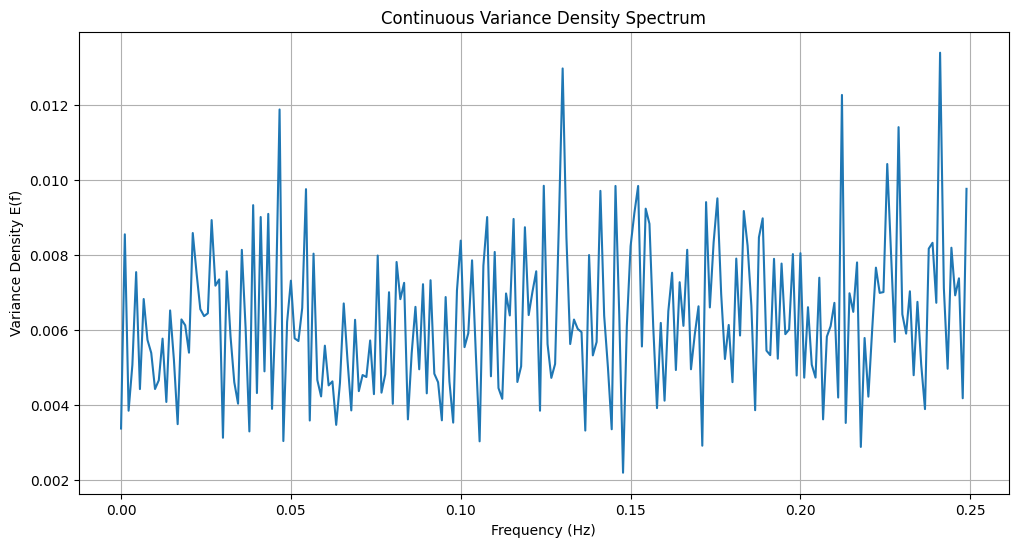

In [258]:
plt.figure(figsize=(12, 6))
plt.plot(pos_freqs, disc_variance_density)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Variance Density E(f)')
plt.title('Continuous Variance Density Spectrum')
plt.grid()
plt.show()

## Energy Desnity Spectrum

$$E_{\text{Energy}}(f) = \rho g E_{\text{variance}}(f)$$

Where p details the density of the medium. In the case of freshwater (1000kg/$m^3$) and salt water (1025 kg/ $m^3$).
$g$ is gravitational acceleration ($9.81$ m/ $s^2$)

In [259]:
p = 1025
g = 9.81

energy_spectrum = disc_variance_density * p * g

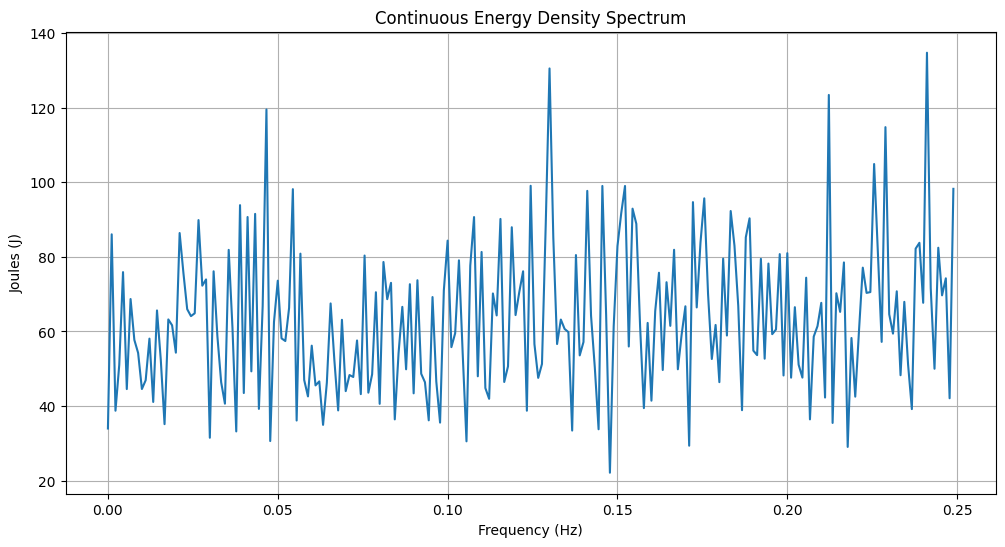

In [260]:
plt.figure(figsize=(12, 6))
plt.plot(pos_freqs, energy_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Joules (J)')
plt.title('Continuous Energy Density Spectrum')
plt.grid()
plt.show()